# "Modulo 5"
> "Analisi DMRG del modello di Ising 1D ad interazioni random"

A differenza dei precedenti moduli in questa relazione non mi occuperò di studiare sistemi con interazioni a lunga distanza random poiché il DMRG si basa fondamentalmente su interazioni a primi vicini. Sono possibili estensioni per considerare interazioni a lungo raggio, ma richiedono un notevole sforzo sia di implementazione che computazionale. Studierò comunque il comportamento di una catena unidimensionale tipo Ising, ma considerando i valori delle costanti di accoppiamento dipendenti dalla posizione del sito rispetto alla catena, con valori random.

La **Density Matrix Renormalization Group** è una tecnica numerica iterativa che consente di trovare il ground state, ed eventualmente pochi altri stati eccitati, di un sistema quantistico a bassa dimensionalità in una maniera estremamente efficiente. 
È un metodo approssimato che si ispira alla rinormalizzazione numerica alla Wilson, ma il cui funzionamento si basa sull'*entanglement bipartito* per il ground state di $\hat{H}$. Se l'Hamiltoniana del sistema può essere scritta come somma di termini locali riferiti ad un sito e ai suoi primi vicini e nel caso in cui il Ground State risulti non degenere, per il caso unidimensionale è dimostrata la validità dell'*Area Law*: considerando uno stato puro $|\psi⟩_{AB}$ di un sistema quantistico bipartito AB, questa proprietà esprime la dipendenza dell'entropia di Von Neumann della partizione A dalla dimensione del confine tra A e B. $$ S(\rho_A) \sim dim(bound(A|B))$$
in cui 
$$\rho_A = Tr_B(|\psi⟩_{AB}⟨\psi|)$$






Una generica Hamiltoniana che soddisfa queste condizioni può essere scritta come:

### $$ \hat{H}=\sum_{i=1}^L ( \sum_\alpha J_i^{(\alpha)} \hat{S}_i^{(\alpha)} \hat{T}_{i+1}^{(\alpha)} +\sum_\beta B_i^{(\beta)} \hat{V}_i^{(\beta)} ) $$

L'Hamiltoniana del modello di Ising quantistico 1D rientra in questa forma:

### $$ \hat{H} = -\sum_{i}^{L-1} J_{i}\sigma_i^z \sigma_{i+1}^z - \sum_{i}^L g_i \sigma_i^x - \sum_{i}^L h_i \sigma_i^z$$



L'algoritmo DMRG Infinite-System si articola in alcuni step:
1. Si parte da un blocco $B(1,d)$, composto dal solo sito estremo di sinistra, di cui si definisce l'Hamiltoniana $\hat{H}_B$, nel codice *BlockH*. Spazio di Hilbert di dimensione $d$.

2. Si costruisce l'*Enlarged Block* aggiungendo al blocco precedente il sito adiacente destro e si costruisce l'hamiltoniana corrispondente $\hat{H}_E$:
$$ \hat{H}_E = \hat{H}_B \otimes \mathbb{1}_{sito} + \mathbb{1}_B \otimes \hat{H}_{sito} + \hat{H}_{B-sito} $$ Spazio di Hilbert di dimensione $d^2$.

3. Si costruisce il *Super-block* aggiundendo al blocco precedente un blocco speculare, considerando il fatto che il sistema in esame è simmetrico per riflessione rispetto al centro della catena, il collegamento è dato dall'interazione dei due siti esterni aggiunti al passo precedente. L'Hamiltoniana del *Super-block* diventa:
$$ \hat{H}_{SB} = \hat{H}_E \otimes \mathbb{1}_{E'} + \mathbb{1}_E \otimes \hat{H}_{E'} + \hat{H}_{E-E'} $$
La cui dimensione è $d^4$.

4. Si trova l'autovalore minore ed il corrispondente autovettore di $\hat{H}_{SB}$, ovvero il Ground State $|\psi_{gs}⟩$ e la sua energia $E_{gs}$.

5. Si calcola la matrice di densità ridotta $\rho_L$ relativa al blocco di sinistra:
$\rho_L=Tr_R |\psi_{gs}⟩⟨\psi_{gs}|$, che operativamente nel codice è stato implementato calcolando $\rho_L=\psi_{gs}\psi_{gs}^\dagger$.

6. Si diagonalizza $\rho_L$ ordinando gli autovalori $\lambda_i$ in senso decrescente e si ricava la rappresentazione della matrice densità:
$$\rho_L = \sum_{i=1}^{d^2}\lambda_i |w_i⟩⟨w_i| $$
dove $|w_i⟩$ è l'autovettore corrispondente all'autovalore $\lambda_i$.

7. 

8. 


Per tutti i modelli presentati si considereranno le condizioni al bordo aperte.

L'osservabile di cui andremo a studiare l'andamento per ogni tipo di modello è l'entropia di Von Neumann definita come:
$$ S(\rho) = -Tr[\rho log(\rho)] = -\sum_i \lambda_i log(\lambda_i)$$

In [8]:
#collapse
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as ssl
import scipy.sparse as ss

## Infinite-System DMRG per il modello di Ising

Di seguito è presentato il codice che implementa l'Infinite-System DMRG per un modello di Ising quantistico 1D. Il codice restituisce i grafici dell'andamento dell'entropia al variare dell'intensità del campo trasverso, parametrizzato da $g$ che varia da 0 a 2. Per ogni run dell'algoritmo $J_i=J$ e $g_i=g$ sono costanti e $h_i=0$  $\forall i$. Poichè il comportamente del sistema non dipende da entrambe le variabili diverse da zero, ma solo dal loro rapporto, consideriamo $J=1$. Ad ogni grafico corrisponde una diversa taglia del sistema descritta in legenda.

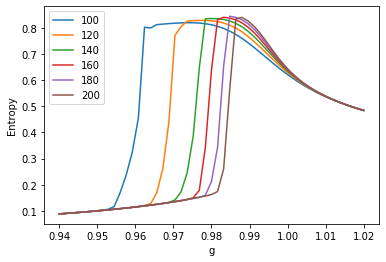

In [25]:
m=9              # Dimensione massima dello spazio di Hilbert del sistema approssimato
NIter=200        # Numero di iterazioni dell'algoritmo
rep=50           # Numero di punti del grafico 
rep+=1
gmax=1.02
ling=np.linspace(0.94,gmax,rep)
linell=2**np.arange(3,8)

Evec=np.zeros(rep)
Entropy=np.zeros(rep)

graphs=np.zeros((rep,NIter))


# inizializzazione degli operatori

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

ggg=0

for g in ling:
    
    #blocchi iniziali
    BlockSz = Sz
    BlockSx = Sx
    BlockI  = I
    BlockH  = g*Sx
    Energy = 0

    for l in range(NIter):
        SystSize = 2*l + 4

    # Get the 2m-dimensional operators for the block + site

        BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - np.kron(BlockSz, Sz) 
        BlockSz = np.kron(BlockI, Sz)
        BlockSx = np.kron(BlockI, Sx)
        BlockI  = np.kron(BlockI, I)

    # Matrice dell'Hamiltoniana per il Super-Blocco
        H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - np.kron(BlockSz, BlockSz)
        H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

    # Diagonalizzazione dell'Hamiltoniana
        LastEnergy = Energy
        Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
        Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
        EnergyPerBond = (Energy - LastEnergy) / 2
        Ener2 = Energy / SystSize


    # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

    # Costruzione della matrice densità
        nr=Psi.size
        Dim = int(np.sqrt(nr))
        PsiMatrix = np.reshape(Psi,(Dim,Dim))
        Rho = PsiMatrix @ PsiMatrix.T

    # Diagonalizzazione della matrice densità
        D,V = np.linalg.eigh(Rho)
        D=D[::-1]  # descending
        Index=np.arange(Dim)
        Index=Index[::-1]
        V=V[:,Index]

    # Construzione dell'operatore di troncamento
        NKeep = min(D.size, m)
        Omatr = V[:,:NKeep]
        TruncationError = 1 - sum(D[:NKeep])
        
        
        Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))

    # Trasformazione degli operatori dei blocchi nella base troncata
        BlockH  = Omatr.T @ BlockH  @ Omatr
        BlockSz = Omatr.T @ BlockSz @ Omatr
        BlockSx = Omatr.T @ BlockSx @ Omatr
        BlockI =  Omatr.T @ BlockI  @ Omatr
        
        graphs[ggg,l]=Ent
        
    ell=SystSize
    
    Evec[ggg]=Energy
    Entropy[ggg]=Ent
    
    ggg+=1

for i in range(5,11):
    plt.plot(ling,graphs[:,2*i*10-1],label=2*i*10)
plt.legend()
plt.xlabel('g')
plt.ylabel('Entropy')
plt.show()

Si può notare come all'aumentare della taglia il valore di $g$ corrispondente al picco dell'entropia converga ad 1, come previsto teoricamente, ed il picco si alzi diventando sempre più stretto, indicando nel limite termodinamico una transizione di fase. Per valori di $g$ maggiori di 1 l'entropia si assesta ad un valore maggiore di zero, effetto delle condizioni al bordo aperte.

## Interazioni a valori random
Di seguito è riportato il grafico, ed il codice espandibile, di un modello di Ising 1D in cui i valori di $J_i$ non sono tutti uguali ad 1, ma sono estratti random da una distribuzione normale con media 1 e varianza 0.3 in questo caso.
Ad ogni ciclo sono estratti due numeri random, dalla stessa distribuzione, uno per l'interazione Blocco-Sito ed uno per l'interazione tra due *Enlarged Block*.

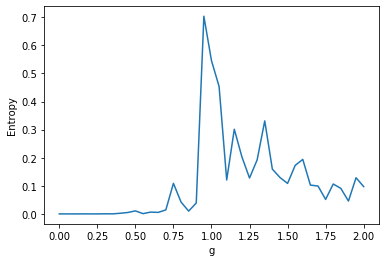

In [35]:
#collapse
m=8
NIter=200
rep=40
rep+=1
gmax=2
ling=np.linspace(0,gmax,rep)


Evec=np.zeros(rep)
Entropy=np.zeros(rep)
ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
for gm in ling:
    Ent=0
    BlockSz = Sz
    BlockSx = Sx
    BlockI  = I
    BlockH  = gm*Sx
    Energy = 0

    for l in range(NIter):
        SystSize = 2*l + 4

        g=gm
        j1=np.random.default_rng().normal(1, .3)

    # Get the 2m-dimensional operators for the block + site

        BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - j1*np.kron(BlockSz, Sz) 
        BlockSz = np.kron(BlockI, Sz)
        BlockSx = np.kron(BlockI, Sx)
        BlockI  = np.kron(BlockI, I)

    # HAMILTONIAN MATRIX for superblock
        j2=np.random.default_rng().normal(1, .3)

        H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - j2*np.kron(BlockSz, BlockSz)
        H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

    # Diagonalizing the Hamiltonian
        LastEnergy = Energy
        Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
        Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
        EnergyPerBond = (Energy - LastEnergy) / 2
        Ener2 = Energy / SystSize


    # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

    # Form the reduced density matrix
        nr=Psi.size
        Dim = int(np.sqrt(nr))
        PsiMatrix = np.reshape(Psi,(Dim,Dim))
        Rho = PsiMatrix @ PsiMatrix.T

    # Diagonalize the density matrix
        D,V = np.linalg.eigh(Rho)
        D=D[::-1]  # descending
        Index=np.arange(Dim)
        Index=Index[::-1]
        V=V[:,Index]

    # Construct the truncation operator
        NKeep = min(D.size, m)

        Omatr = V[:,:NKeep]

        TruncationError = 1 - sum(D[:NKeep])


    # Transform the block operators into the truncated basis
        BlockH  = Omatr.T @ BlockH  @ Omatr
        BlockSz = Omatr.T @ BlockSz @ Omatr
        BlockSx = Omatr.T @ BlockSx @ Omatr
        BlockI  = Omatr.T @ BlockI  @ Omatr


    Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
    #Evec[ggg]=Energy
    Entropy[ggg]=Ent
    ggg+=1

plt.plot(ling,Entropy)
plt.xlabel('g')
plt.ylabel('Entropy')
plt.show()

Si può notare come l'andamento del grafico non si discosti troppo da quello del caso precedente. Risulta infatti un esserci una prima zona, per bassi valori di $g$, in cui l'entropia è piccola, un rapido aumento ed un picco nei pressi di $g=1$, in seguito un decremento ed un assestamento sempre dovuto alle condizioni al bordo aperte. Risultano evidenti comunque molte fluttuazioni lungo il grafico, effetto dovuto appunto alle interazioni tra primi vicini a valori random. 

Bisogna comunque sottolineare che per ogni valore di $g$ l'entropia calcolata si riferisce ad una catena con valori $J_i$ indipendenti dalle altre catene a diversi di $g$, per ogni valore di $g$ è necessario infatti calcolare una Hamiltoniana che ha $J_i$ completamente nuovi e questo giustifica in parte le grandi oscillazioni che si possono osservare. 

Un altro motivo, che verrà studiato meglio nel proseguo della relazione, consiste nel fatto che per una catena di Ising "normale" il punto di transizioni si ha, come detto in precedenza, per valori di $g$ e $J$ tali che $g/J=1$, quindi delle fluttuazioni su $J$ possono comportare grandi fluttuazioni sull'entropia finale del sistema.

## Fluttuazioni mediate

Al fine di diminuire le fluttuazioni presenti in ogni grafico in modo da ricavare dei comportamenti generali, sono state calcolate varie realizzazioni di catene di Ising con interazioni a valori random aventi la stessa media 1 e la stessa varianza 0.3, per poi calcolarne la media, evidenziata con un tratto nero più spesso.

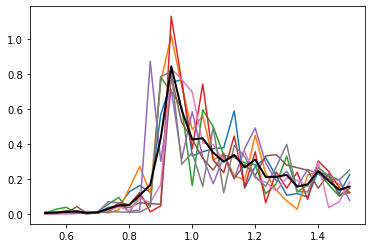

In [19]:
#collapse
m=10
NIter=200
rep=30
rep+=1
gmax=1.5
ling=np.linspace(0.5,gmax,rep)

nrip=8

Evec=np.zeros((rep,nrip))
Entropy=np.zeros((rep,nrip))
ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
for gm in ling:  
    
    for rip in range(nrip):
        BlockSz = Sz
        BlockSx = Sx
        BlockI  = I
        BlockH  = gm*Sx
        Energy = 0

        for l in range(NIter):
            SystSize = 2*l + 4

            g=gm
            j1=np.random.default_rng().normal(1, .3)
            
            # Get the 2m-dimensional operators for the block + site

            BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - j1*np.kron(BlockSz, Sz) 
            BlockSz = np.kron(BlockI, Sz)
            BlockSx = np.kron(BlockI, Sx)
            BlockI  = np.kron(BlockI, I)

            # HAMILTONIAN MATRIX for superblock
            j2=np.random.default_rng().normal(1, .3)
            
            H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - j2*np.kron(BlockSz, BlockSz)
            H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

            # Diagonalizing the Hamiltonian
            LastEnergy = Energy
            Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
            Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
            EnergyPerBond = (Energy - LastEnergy) / 2
            Ener2 = Energy / SystSize


            # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

            # Form the reduced density matrix
            nr=Psi.size
            Dim = int(np.sqrt(nr))
            PsiMatrix = np.reshape(Psi,(Dim,Dim))
            Rho = PsiMatrix @ PsiMatrix.T

            # Diagonalize the density matrix
            D,V = np.linalg.eigh(Rho)
            D=D[::-1]  # descending
            Index=np.arange(Dim)
            Index=Index[::-1]
            V=V[:,Index]

            # Construct the truncation operator
            NKeep = min(D.size, m)

            Omatr = V[:,:NKeep]

            TruncationError = 1 - sum(D[:NKeep])


            # Transform the block operators into the truncated basis
            BlockH  = Omatr.T @ BlockH  @ Omatr
            BlockSz = Omatr.T @ BlockSz @ Omatr
            BlockSx = Omatr.T @ BlockSx @ Omatr
            BlockI  = Omatr.T @ BlockI  @ Omatr


        Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
        Evec[ggg,rip]=Energy
        Entropy[ggg,rip]=Ent
    ggg+=1
    

plt.plot(ling[1:],Entropy[1:])
plt.plot(ling[1:],np.sum(Entropy[1:],axis=1)/nrip,color='k', linewidth=2.0)
plt.show()

Nonostante la permanenza di fluttuazioni importanti del grafico possiamo notare come la forma generale resti sostanzialmente invariata, ma possiamo osservare uno spostamento del picco verso sinistra, effetto non dovuto alla statistica, in quanto altre simulazioni, come mostrato sotto, portano alle stesse conclusioni. 

## Comportamento per diverse varianze

È possibile quindi pensare ad una correlazione tra la varianza della distribuzione da cui viengono estratti i $J_i$ e la posizione del picco dell'entropia?

Per rispondere a questa domanda sono state calcolate le medie di **molte** realizzazioni di catene di Ising con interazioni a valori random, corrispondenti a **diversi** valori di varianze, che vanno da 0.1 ad 1.

Di seguito sono riportati i grafici, insieme al codice espandibile, dell'andamento dell'entropia in funzione del parametro $g$, per i diversi valori della varianza.

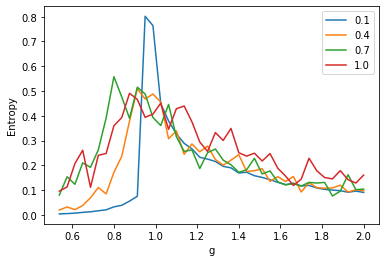

In [38]:
#collapse
m=8
NIter=200
rep=40
rep+=1
gmax=1.5
Nmedie=4
ling=np.linspace(0.5,gmax,rep)
linsig=np.linspace(0.1,1,Nmedie)


nrip=20

#ling=ling[int(30*rep/100):]
Evec=np.zeros((rep,nrip))
Entropy=np.zeros((rep,nrip))
MEnt=np.zeros((Nmedie,rep-1))

ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks

sss=0
for sig in linsig:
    ggg=0 
    for gm in ling: 

        for rip in range(nrip):
            BlockSz = Sz
            BlockSx = Sx
            BlockI  = I
            BlockH  = gm*Sx
            Energy = 0

            for l in range(NIter):
                SystSize = 2*l + 4

                
                g=gm
                j1=np.random.default_rng().normal(1, sig)


                # Get the 2m-dimensional operators for the block + site

                BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - j1*np.kron(BlockSz, Sz) 
                BlockSz = np.kron(BlockI, Sz)
                BlockSx = np.kron(BlockI, Sx)
                BlockI  = np.kron(BlockI, I)

                # HAMILTONIAN MATRIX for superblock
                
                j2=np.random.default_rng().normal(1, sig)

                H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - j2*np.kron(BlockSz, BlockSz)
                H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

                # Diagonalizing the Hamiltonian
                LastEnergy = Energy
                Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
                Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
                EnergyPerBond = (Energy - LastEnergy) / 2
                Ener2 = Energy / SystSize


                # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

                # Form the reduced density matrix
                nr=Psi.size
                Dim = int(np.sqrt(nr))
                PsiMatrix = np.reshape(Psi,(Dim,Dim))
                Rho = PsiMatrix @ PsiMatrix.T

                # Diagonalize the density matrix
                D,V = np.linalg.eigh(Rho)
                D=D[::-1]  # descending
                Index=np.arange(Dim)
                Index=Index[::-1]
                V=V[:,Index]

                # Construct the truncation operator
                NKeep = min(D.size, m)

                Omatr = V[:,:NKeep]

                TruncationError = 1 - sum(D[:NKeep])


                # Transform the block operators into the truncated basis
                BlockH  = Omatr.T @ BlockH  @ Omatr
                BlockSz = Omatr.T @ BlockSz @ Omatr
                BlockSx = Omatr.T @ BlockSx @ Omatr
                BlockI  = Omatr.T @ BlockI  @ Omatr



            #print(SystSize, Energy, EnergyPerBond, Ener2, TruncationError)

            Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
            #Evec[ggg,rip]=Energy
            Entropy[ggg,rip]=Ent
        ggg+=1
    
    MEnt[sss]=np.sum(Entropy[1:],axis=1)/nrip
    sss+=1
    
    #Spectrum=ssl.eigsh(H_super)[0]
    
for i in range(4):
    plt.plot(ling[1:],MEnt[i],label=linsig[i])
plt.legend()
plt.xlabel('g')
plt.ylabel('Entropy')
plt.show()

Possiamo notare come per valori della varianza maggiori di 0.1 il picco, oltre ad abbassarsi notevolmente, sembra spostarsi progressivamente più a sinistra. 

Per approfondire meglio questo effetto andremo a fare gli stessi passaggi fatti finora, ma considerando le fluttuazioni random sul campo esterno $g$.

## Campi esterni a valori random
Di seguito è riportato il grafico, ed il codice espandibile, di un modello di Ising 1D in cui i valori di $g_i$ non sono uguali per tutta la catena, ma vengono estratti da una distribuzione normale con media $g_m$ variabile e varianza, in questo caso, uguale a 0.4.


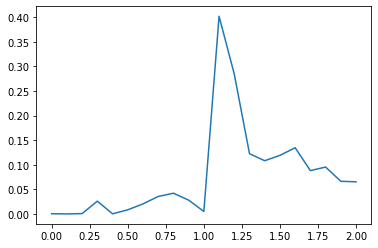

In [28]:
#collapse
m=10
NIter=200
rep=20
rep+=1
gmax=2
ling=np.linspace(0,gmax,rep)


Evec=np.zeros(rep)
Entropy=np.zeros(rep)
ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
for gm in ling:

    Ent=0
    BlockSz = Sz
    BlockSx = Sx
    BlockI  = I
    BlockH = np.random.default_rng().normal(gm, .4)*Sx
    Energy = 0

    for l in range(NIter):
        SystSize = 2*l + 4

        g=np.random.default_rng().normal(gm, .4)

    # Get the 2m-dimensional operators for the block + site

        BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - np.kron(BlockSz, Sz) 
        BlockSz = np.kron(BlockI, Sz)
        BlockSx = np.kron(BlockI, Sx)
        BlockI  = np.kron(BlockI, I)

    # HAMILTONIAN MATRIX for superblock

        H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - np.kron(BlockSz, BlockSz)
        H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

    # Diagonalizing the Hamiltonian
        LastEnergy = Energy
        Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
        Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
        EnergyPerBond = (Energy - LastEnergy) / 2
        Ener2 = Energy / SystSize


    # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

    # Form the reduced density matrix
        nr=Psi.size
        Dim = int(np.sqrt(nr))
        PsiMatrix = np.reshape(Psi,(Dim,Dim))
        Rho = PsiMatrix @ PsiMatrix.T

    # Diagonalize the density matrix
        D,V = np.linalg.eigh(Rho)
        D=D[::-1]  # descending
        Index=np.arange(Dim)
        Index=Index[::-1]
        V=V[:,Index]

    # Construct the truncation operator
        NKeep = min(D.size, m)

        Omatr = V[:,:NKeep]

        TruncationError = 1 - sum(D[:NKeep])


            # Transform the block operators into the truncated basis
        BlockH  = Omatr.T @ BlockH  @ Omatr
        BlockSz = Omatr.T @ BlockSz @ Omatr
        BlockSx = Omatr.T @ BlockSx @ Omatr
        BlockI  = Omatr.T @ BlockI  @ Omatr



    #print(SystSize, Energy, EnergyPerBond, Ener2, TruncationError)

    Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
    #Evec[ggg]=Energy
    Entropy[ggg]=Ent
    ggg+=1

    
plt.plot(ling,Entropy)
plt.show()

Oltre a presentare le stesse caratteristiche di prima presenta uno spostamento del picco verso destra, in maniera opposta rispetto a prima.

## Fluttuazioni mediate
Di seguito sono state calcolate varie realizzazioni di catene di Ising con campi esterni a valori random, per poi calcolarne la media, in maniera da essere sicuri che questo effetto non sia solo statistico.

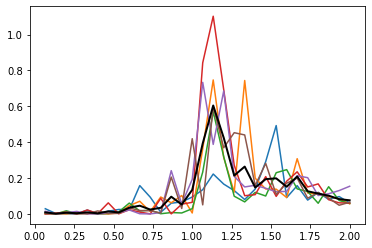

In [107]:
#collapse
m=8
NIter=200
rep=30
rep+=1
gmax=2
ling=np.linspace(0,gmax,rep)


nrip=6

#ling=ling[int(30*rep/100):]
Evec=np.zeros((rep,nrip))
Entropy=np.zeros((rep,nrip))
ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
for gm in ling:
    
    for rip in range(nrip):
        BlockSz = Sz
        BlockSx = Sx
        BlockI  = I
        BlockH = np.random.default_rng().normal(gm, .5)*Sx
        Energy = 0

        for l in range(NIter):
            SystSize = 2*l + 4

            g=np.random.default_rng().normal(gm, .5)

            
            # Get the 2m-dimensional operators for the block + site

            BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - np.kron(BlockSz, Sz) 
            BlockSz = np.kron(BlockI, Sz)
            BlockSx = np.kron(BlockI, Sx)
            BlockI  = np.kron(BlockI, I)

            # HAMILTONIAN MATRIX for superblock
            
            H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - np.kron(BlockSz, BlockSz)
            H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

            # Diagonalizing the Hamiltonian
            LastEnergy = Energy
            Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
            Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
            EnergyPerBond = (Energy - LastEnergy) / 2
            Ener2 = Energy / SystSize


            # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

            # Form the reduced density matrix
            nr=Psi.size
            Dim = int(np.sqrt(nr))
            PsiMatrix = np.reshape(Psi,(Dim,Dim))
            Rho = PsiMatrix @ PsiMatrix.T

            # Diagonalize the density matrix
            D,V = np.linalg.eigh(Rho)
            D=D[::-1]  # descending
            Index=np.arange(Dim)
            Index=Index[::-1]
            V=V[:,Index]

            # Construct the truncation operator
            NKeep = min(D.size, m)

            Omatr = V[:,:NKeep]

            TruncationError = 1 - sum(D[:NKeep])


            # Transform the block operators into the truncated basis
            BlockH  = Omatr.T @ BlockH  @ Omatr
            BlockSz = Omatr.T @ BlockSz @ Omatr
            BlockSx = Omatr.T @ BlockSx @ Omatr
            BlockI  = Omatr.T @ BlockI  @ Omatr


            
        #print(SystSize, Energy, EnergyPerBond, Ener2, TruncationError)

        Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
        Evec[ggg,rip]=Energy
        Entropy[ggg,rip]=Ent
    ggg+=1
    
    
    #Spectrum=ssl.eigsh(H_super)[0]
    
plt.plot(ling[1:],Entropy[1:])
plt.plot(ling[1:],np.sum(Entropy[1:],axis=1)/nrip,color='k', linewidth=2.0)
plt.show()

Anche in questo caso si può osservare come lo spostamento verso destra non dipenda dalla statistica.

## Comportamento per diverse varianze

Guardiamo ora il comportamento delle medie dei grafici dell'entropia per alcuni valori di varianze diverse.

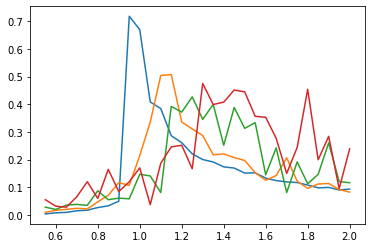

In [128]:
#collapse
m=8
NIter=200
rep=30
rep+=1
gmax=2
Nmedie=5
ling=np.linspace(0.5,gmax,rep)
linsig=np.linspace(0.1,1,Nmedie)


nrip=8

#ling=ling[int(30*rep/100):]
Evec=np.zeros((rep,nrip))
Entropy=np.zeros((rep,nrip))
MEnt=np.zeros((Nmedie,rep-1))

ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks

sss=0
for sig in linsig:
    ggg=0 
    for gm in ling: 

        for rip in range(nrip):
            BlockSz = Sz
            BlockSx = Sx
            BlockI  = I
            #BlockH  = gm*Sx
            BlockH = np.random.default_rng().normal(gm, sig)*Sx
            Energy = 0

            for l in range(NIter):
                SystSize = 2*l + 4

                g=np.random.default_rng().normal(gm, sig)


                # Get the 2m-dimensional operators for the block + site

                BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - np.kron(BlockSz, Sz) 
                BlockSz = np.kron(BlockI, Sz)
                BlockSx = np.kron(BlockI, Sx)
                BlockI  = np.kron(BlockI, I)

                # HAMILTONIAN MATRIX for superblock

                H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - np.kron(BlockSz, BlockSz)
                H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

                # Diagonalizing the Hamiltonian
                LastEnergy = Energy
                Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
                Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
                EnergyPerBond = (Energy - LastEnergy) / 2
                Ener2 = Energy / SystSize


                # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

                # Form the reduced density matrix
                nr=Psi.size
                Dim = int(np.sqrt(nr))
                PsiMatrix = np.reshape(Psi,(Dim,Dim))
                Rho = PsiMatrix @ PsiMatrix.T

                # Diagonalize the density matrix
                D,V = np.linalg.eigh(Rho)
                D=D[::-1]  # descending
                Index=np.arange(Dim)
                Index=Index[::-1]
                V=V[:,Index]

                # Construct the truncation operator
                NKeep = min(D.size, m)

                Omatr = V[:,:NKeep]

                TruncationError = 1 - sum(D[:NKeep])


                # Transform the block operators into the truncated basis
                BlockH  = Omatr.T @ BlockH  @ Omatr
                BlockSz = Omatr.T @ BlockSz @ Omatr
                BlockSx = Omatr.T @ BlockSx @ Omatr
                BlockI  = Omatr.T @ BlockI  @ Omatr



            #print(SystSize, Energy, EnergyPerBond, Ener2, TruncationError)

            Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
            #Evec[ggg,rip]=Energy
            Entropy[ggg,rip]=Ent
        ggg+=1
    
    MEnt[sss]=np.sum(Entropy[1:],axis=1)/nrip
    sss+=1
    
    #Spectrum=ssl.eigsh(H_super)[0]
    
plt.plot(ling[1:],MEnt.T)
#plt.legend()
plt.show()

Anche in questo caso si può apprezzare un graduale allontanamento del picco verso destra, nel senso opposto che nel caso delle interazioni a primi vicini con valori random.

## Una possibile spiegazione

Ricordandoci che il punto critico del modello di Ising "normale" si trova per valori di $g$ e $J$ tali che $g/J=1$ possiamo notare che i due parametri competono in maniera reciproca al punto di transizione, quindi è legittimo pensare di aver "sbagliato" ad imporre un tipo di rumore gaussiano ad entrambi i parametri, mentre in uno dei due avremmo dovuto imporre un rumore preso dall'inverso di una distribuzione gaussiana.

Per testare questa ipotesi andiamo a cambiare il parametro $J$ nel codice in $1/J$ che rimane comunque con la stessa media poichè essa è sempre stata fissata ad 1.

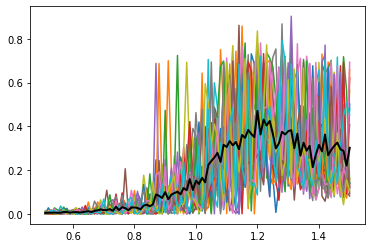

In [44]:
#collapse
m=9
NIter=200
rep=100
rep+=1
gmax=1.5
ling=np.linspace(0.5,gmax,rep)

nrip=20

Evec=np.zeros((rep,nrip))
Entropy=np.zeros((rep,nrip))
ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
for gm in ling:  
    
    for rip in range(nrip):
        BlockSz = Sz
        BlockSx = Sx
        BlockI  = I
        BlockH  = gm*Sx
        Energy = 0

        for l in range(NIter):
            SystSize = 2*l + 4

            g=gm
            j1=np.random.default_rng().normal(1, .4)
            
            # Get the 2m-dimensional operators for the block + site

            BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - np.kron(BlockSz, Sz)/j1
            BlockSz = np.kron(BlockI, Sz)
            BlockSx = np.kron(BlockI, Sx)
            BlockI  = np.kron(BlockI, I)

            # HAMILTONIAN MATRIX for superblock
            j2=np.random.default_rng().normal(1, .4)
            
            H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - np.kron(BlockSz, BlockSz)/j2
            H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

            # Diagonalizing the Hamiltonian
            LastEnergy = Energy
            Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
            Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
            EnergyPerBond = (Energy - LastEnergy) / 2
            Ener2 = Energy / SystSize


            # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

            # Form the reduced density matrix
            nr=Psi.size
            Dim = int(np.sqrt(nr))
            PsiMatrix = np.reshape(Psi,(Dim,Dim))
            Rho = PsiMatrix @ PsiMatrix.T

            # Diagonalize the density matrix
            D,V = np.linalg.eigh(Rho)
            D=D[::-1]  # descending
            Index=np.arange(Dim)
            Index=Index[::-1]
            V=V[:,Index]

            # Construct the truncation operator
            NKeep = min(D.size, m)

            Omatr = V[:,:NKeep]

            TruncationError = 1 - sum(D[:NKeep])


            # Transform the block operators into the truncated basis
            BlockH  = Omatr.T @ BlockH  @ Omatr
            BlockSz = Omatr.T @ BlockSz @ Omatr
            BlockSx = Omatr.T @ BlockSx @ Omatr
            BlockI  = Omatr.T @ BlockI  @ Omatr


        Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
        Evec[ggg,rip]=Energy
        Entropy[ggg,rip]=Ent
    ggg+=1

EntMed1=np.sum(Entropy[1:],axis=1)/nrip

plt.plot(ling[1:],Entropy[1:])
plt.plot(ling[1:],EntMed1,color='k', linewidth=2.0)
plt.show()

A parte la grande fluttuazione dei singoli grafici, possiamo notare come in media effettivamente il picco si sia spostato verso valori di $g$ maggiori, contrariamente a prima e in maniera concorde con il caso del rumore su $g$.

Per controllare che quest'ultima affermazione andremo a fare lo stesso calcolo con gli stessi valori dell'algoritmo e con la stessa varianza ma su $g$ come prima.

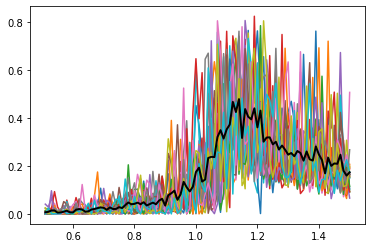

In [45]:
#collapse
m=9
NIter=200
rep=100
rep+=1
gmax=1.5
ling=np.linspace(0.5,gmax,rep)


nrip=20

#ling=ling[int(30*rep/100):]
Evec=np.zeros((rep,nrip))
Entropy=np.zeros((rep,nrip))
ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
for gm in ling:
    
    for rip in range(nrip):
        BlockSz = Sz
        BlockSx = Sx
        BlockI  = I
        BlockH = np.random.default_rng().normal(gm, .4)*Sx
        Energy = 0

        for l in range(NIter):
            SystSize = 2*l + 4

            g=np.random.default_rng().normal(gm, .4)

            
            # Get the 2m-dimensional operators for the block + site

            BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - np.kron(BlockSz, Sz) 
            BlockSz = np.kron(BlockI, Sz)
            BlockSx = np.kron(BlockI, Sx)
            BlockI  = np.kron(BlockI, I)

            # HAMILTONIAN MATRIX for superblock
            
            H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - np.kron(BlockSz, BlockSz)
            H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

            # Diagonalizing the Hamiltonian
            LastEnergy = Energy
            Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
            Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
            EnergyPerBond = (Energy - LastEnergy) / 2
            Ener2 = Energy / SystSize


            # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

            # Form the reduced density matrix
            nr=Psi.size
            Dim = int(np.sqrt(nr))
            PsiMatrix = np.reshape(Psi,(Dim,Dim))
            Rho = PsiMatrix @ PsiMatrix.T

            # Diagonalize the density matrix
            D,V = np.linalg.eigh(Rho)
            D=D[::-1]  # descending
            Index=np.arange(Dim)
            Index=Index[::-1]
            V=V[:,Index]

            # Construct the truncation operator
            NKeep = min(D.size, m)

            Omatr = V[:,:NKeep]

            TruncationError = 1 - sum(D[:NKeep])


            # Transform the block operators into the truncated basis
            BlockH  = Omatr.T @ BlockH  @ Omatr
            BlockSz = Omatr.T @ BlockSz @ Omatr
            BlockSx = Omatr.T @ BlockSx @ Omatr
            BlockI  = Omatr.T @ BlockI  @ Omatr


            
        #print(SystSize, Energy, EnergyPerBond, Ener2, TruncationError)

        Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
        Evec[ggg,rip]=Energy
        Entropy[ggg,rip]=Ent
    ggg+=1
    
    
EntMed2=np.sum(Entropy[1:],axis=1)/nrip
    
plt.plot(ling[1:],Entropy[1:])
plt.plot(ling[1:],EntMed2,color='k', linewidth=2.0)
plt.show()

Anche in questo caso osserviamo lo stesso spostamento del picco verso destra anche se il valore di $g$ relativo al picco non è lo stesso che nel caso precedente. Questo fatto potrebbe essere dovuto o alla statistica o, più probabilmente, al fatto che per ritrovare la stessa distribuzione la varianza su $g$ non deve essere la stessa di quella su $J$ che poi deve essere invertita, ma comunque il comportamento generale sembra essere più o meno quello, come dimostrato dalla differenza delle due medie precedenti che mostrano comunque scostamenti non eccessivi dallo zero.

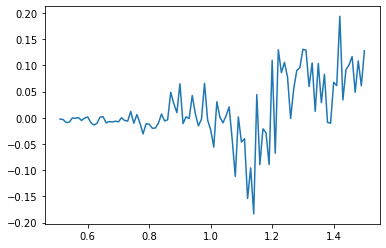

In [47]:
#collapse
plt.plot(ling[1:],EntMed1-EntMed2)
plt.show()